# Split HMC with Hamiltorch

* This notebook demonstrates how to use `hamiltorch` to perform split HMC inference over a neural network.

In [1]:
import torch
import hamiltorch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

try:
    import urllib
    from urllib import urlretrieve
except Exception:
    import urllib.request as urllib
from os import path
import os
import numpy as np

%matplotlib inline

In [2]:
hamiltorch.set_random_seed(123)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
hamiltorch.__version__

'0.4.0.dev1'

## Loading the Data

For this regression example we take the simple regression data set from Izmailov et al. (2019) as it has nice gaps in the data where we can look at the model behaviour.

The functions for loading the data in the next cell almost exclusively come from the git repo:
* "Depth Uncertainty in Neural Networks" https://github.com/cambridge-mlg/DUN/blob/master/src/utils.py 

In [4]:
def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path, mode=0o777)

def load_agw_1d(base_dir, get_feats=False):
    if not path.exists(base_dir + '/agw_data'):
        mkdir(base_dir + '/agw_data')
        urllib.urlretrieve('https://raw.githubusercontent.com/wjmaddox/drbayes/master/experiments/synthetic_regression/ckpts/data.npy',
                           filename=base_dir + '/agw_data/data.npy')

    def features(x):
        return np.hstack([x[:, None] / 2.0, (x[:, None] / 2.0) ** 2])

    data = np.load(base_dir + '/agw_data/data.npy')
    x, y = data[:, 0], data[:, 1]
    y = y[:, None]
    f = features(x)

    x_means, x_stds = x.mean(axis=0), x.std(axis=0)
    y_means, y_stds = y.mean(axis=0), y.std(axis=0)
    f_means, f_stds = f.mean(axis=0), f.std(axis=0)

    X = ((x - x_means) / x_stds).astype(np.float32)
    Y = ((y - y_means) / y_stds).astype(np.float32)
    F = ((f - f_means) / f_stds).astype(np.float32)

    if get_feats:
        return F, Y

    return X[:, None], Y

#### Note the location the data will be stored!!!

folder = '../../../data/'

X, Y = load_agw_1d(folder, get_feats=False)
X = torch.Tensor(X).view(-1,1)
Y = torch.Tensor(Y).view(-1,1)

X_test = torch.linspace(-2,2,500).view(-1,1)

#### This is what the data looks like:

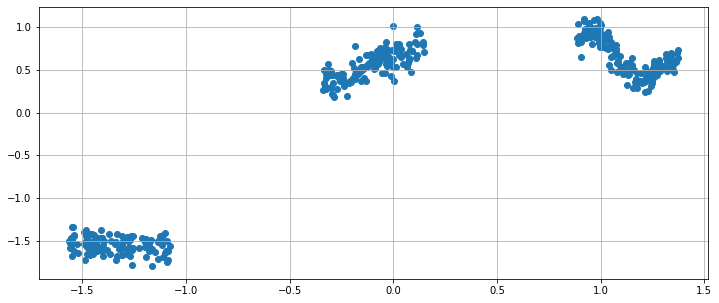

In [5]:
plt.figure(figsize=(12,5))
plt.scatter(X,Y)
plt.grid()
plt.show()

### Let's define our model

* A simple fully connected network:

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

GeForce RTX 2080 with Max-Q Design


## Inference

### Setting the hyperparameters for HMC
* Before we start playing around with the models, we need to define our HMC hyperparameters
* As a reminder, we must set the `step_size` and the trajectory length `L`. We also set the number of samples.
* We also have a few new parameters to set:
    * `store_on_GPU`: this boolean determines whether to move the samples off the GPU during inference. Set to False if you are working with a large model and a small GPU memory.
    * `inv_mass`: `hamiltorch` allows you to set the mass matrix for HMC. For now, we stick with a diagonal mass matrix, such that the inverse mass is just a torch.tensor, which is the same length of the number of NN weights. 
    * `tau_list`: we are assuming a diagonal Gaussian prior for each layer and therefore with 3 linear layers, we need a list `[w1, b1, w2, b2, w3, b3]`, corresponding to the prior precision for each set of weights (wi) and biases (bi).
    * `tau_out`: we must set the `model_loss = 'regression'`, therefore the output precision of the likelihood must also be defined. Instead of doing cross-validation, I cheated and used GPyTorch to set `tau_out` to the inverse of the likelihood noise via GP inference. I left that step out here so that GPyTorch is not needed to run this notebook.
    

In [7]:
step_size = 0.0005
num_samples = 1000
L = 30
burn = -1
store_on_GPU = False
debug = False
model_loss = 'regression'
mass = 1.0

# Effect of tau
# Set to tau = 1000. to see a function that is less bendy (weights restricted to small bends)
# Set to tau = 1. for more flexible

tau = 1.0 # Prior Precision
tau_out = 110.4439498986428 # Output Precision
r = 0 # Random seed


tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)

# Set initial weights
params_init = hamiltorch.util.flatten(net).to(device).clone()
# Set the Inverse of the Mass matrix
inv_mass = torch.ones(params_init.shape) / mass

### Full HMC inference
* As baseline, let's start with full HMC inference over our model.
* We need to set `integrator = hamiltorch.Integrator.EXPLICIT` and `sampler = hamiltorch.Sampler.HMC`.
* We are also using the standard `hamiltorch.sample_model` function and pass all the parameters to it.

In [8]:
print(params_init.shape)
integrator = hamiltorch.Integrator.EXPLICIT
sampler = hamiltorch.Sampler.HMC

hamiltorch.set_random_seed(r)
params_hmc_f = hamiltorch.sample_model(net, X.to(device), Y.to(device), params_init=params_init,
                                       model_loss=model_loss, num_samples=num_samples,
                                       burn = burn, inv_mass=inv_mass.to(device),step_size=step_size,
                                       num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list,
                                       debug=debug, store_on_GPU=store_on_GPU,
                                       sampler = sampler)

# At the moment, params_hmc_f is on the CPU so we move to GPU

params_hmc_gpu = [ll.to(device) for ll in params_hmc_f[1:]]


# Let's predict over the entire test range [-2,2]
pred_list, log_probs_f = hamiltorch.predict_model(net, x = X_test.to(device),
                                                  y = X_test.to(device), samples=params_hmc_gpu,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)
# Let's evaluate the performance over the training data
pred_list_tr, log_probs_split_tr = hamiltorch.predict_model(net, x = X.to(device), y=Y.to(device),
                                                            samples=params_hmc_gpu, model_loss=model_loss,
                                                            tau_out=tau_out, tau_list=tau_list)
ll_full = torch.zeros(pred_list_tr.shape[0])
ll_full[0] = - 0.5 * tau_out * ((pred_list_tr[0].cpu() - Y) ** 2).sum(0)
for i in range(pred_list_tr.shape[0]):
    ll_full[i] = - 0.5 * tau_out * ((pred_list_tr[:i].mean(0).cpu() - Y) ** 2).sum(0)

torch.Size([10401])
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:01:14 | 0d:00:00:00 | #################### | 1000/1000 | 13.47       
Acceptance Rate 0.58


### Plotting
* As one way to test convergence, we can simply see if the log-likelihood (-loss) (Squared Error) has converged.

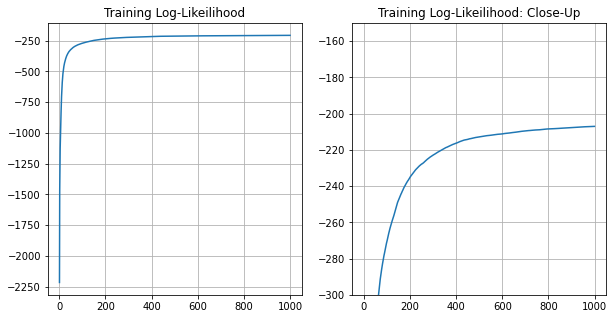

In [9]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.set_title('Training Log-Likeilihood')
ax1.plot(ll_full)
ax1.grid()

ax2.set_title('Training Log-Likeilihood: Close-Up')
ax2.plot(ll_full)
ax2.set_ylim([-300,-150])
ax2.grid()
plt.show()


### Plot the regression for full HMC

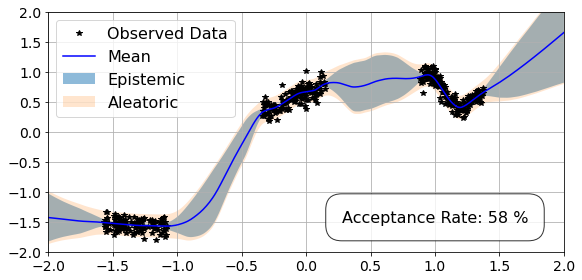

In [10]:
fs = 16

m = pred_list[200:].mean(0).to('cpu')
s = pred_list[200:].std(0).to('cpu')
s_al = (pred_list[200:].var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(8, 4))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(X.numpy(), Y.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(X_test.numpy(), m.numpy(), 'b', rasterized=True)
# Shade between the lower and upper confidence bounds
ax.fill_between(X_test.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(X_test.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
ax.set_ylim([-2, 2])
ax.set_xlim([-2, 2])
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

bbox = {'facecolor': 'white', 'alpha': 0.8, 'pad': 1, 'boxstyle': 'round', 'edgecolor':'black'}
plt.text(1., -1.5, 'Acceptance Rate: 58 %', bbox=bbox, fontsize=16, horizontalalignment='center')


plt.tight_layout()
# plt.savefig('plots/full_hmc.pdf', rasterized=True)
    
plt.show()

* We can check the calibration of our model by looking at how much data falls outside the credible bounds.

In [11]:
m = pred_list_tr[200:].mean(0).to('cpu')
s = pred_list_tr[200:].std(0).to('cpu')
s_al = (pred_list_tr[200:].var(0).to('cpu') + tau_out ** -1) ** 0.5
count_sigma = 0
count_2sigma = 0

for i, p in enumerate(pred_list_tr.mean(0)):
    if Y[i] > m[i] + s_al[i] or Y[i] < m[i] - s_al[i]:
        count_sigma += 1
    if Y[i] > m[i] + 2*s_al[i] or Y[i] < m[i] - 2*s_al[i]:
        count_2sigma += 1

print('Proportion of training data outside standard deviation  (0.318): ', count_sigma / X.shape[0])
print('Proportion of training data outside 2 standard deviation (0.05): ', count_2sigma / X.shape[0])



Proportion of training data outside standard deviation  (0.318):  0.3125
Proportion of training data outside 2 standard deviation (0.05):  0.035


## Novel Symmetric Split HMC
* As in Cobb and Jalaian 2020.
* We can now work with PyTorch dataloaders.
* This will allow us to fit all data on a single GPU, even when the size of the data set increases.
* When we define the batch_size for the data loader this will set the splits.

#### We first define the data loaders with the batch_size

In [12]:
from torch.utils.data import Dataset, DataLoader

class RegressionData(Dataset):
    """Simple Regression Dataset"""

    def __init__(self, x_train, y_train, transform=None):
        """
        Args:
            path (string): Path to the Acoustic folder.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = (self.x_train[idx], self.y_train[idx])

        if self.transform:
            sample = self.transform(sample)

        return sample
    
batch_size = 100

data_tr = RegressionData(X, Y)
data_val = RegressionData(X_test, X_test)


dataloader_tr = DataLoader(data_tr, batch_size=batch_size,
                        shuffle=True, num_workers=4)
dataloader_val = DataLoader(data_val, batch_size=len(X_test),
                        shuffle=False, num_workers=4)

### We can now implement Novel Symmetric Split HMC
* We keep all the parameters the same as for full HMC however there are now some key differences:
    * Notice that we are now using `hamiltorch.samplers.sample_split_model`! This expects a `torch.utils.data.Dataloader`.
    * The other new parameter is the `num_splits`. This sets the number of batches to be included in the inference. Setting `M = X.shape[0] / batch_size` gives us an integer of 4. However if we set `num_splits = 3` then we would only use the first 3 batches.
    * Notice `integrator = hamiltorch.Integrator.SPLITTING` tells the sampler that we are defaulting to novel symmetric split HMC.

In [13]:
M = X.shape[0] / batch_size # Number of subgradient splits

print(params_init.shape)
integrator = hamiltorch.Integrator.SPLITTING
sampler = hamiltorch.Sampler.HMC

hamiltorch.set_random_seed(r)
params_hmc_s = hamiltorch.samplers.sample_split_model(net, dataloader_tr, params_init=params_init,
                                                      num_splits=M, num_samples=num_samples,
                                                      step_size=step_size, num_steps_per_sample=L,
                                inv_mass = inv_mass.to(device), integrator=integrator, debug = debug, store_on_GPU=store_on_GPU, burn = burn,
                                sampler = sampler, tau_out=tau_out, tau_list=tau_list, model_loss=model_loss)

params_hmc_gpu = [ll.to(device) for ll in params_hmc_s[1:]]

pred_list_split, log_probs_split = hamiltorch.predict_model(net, test_loader = dataloader_val, samples=params_hmc_gpu, model_loss=model_loss, tau_out=tau_out, tau_list=tau_list)

pred_list_tr_s, log_probs_split_tr_s = hamiltorch.predict_model(net, x = X.to(device), y=Y.to(device), samples=params_hmc_gpu, model_loss=model_loss, tau_out=tau_out, tau_list=tau_list)

ll_s = torch.zeros(pred_list_tr_s.shape[0])
ll_s[0] = - 0.5 * tau_out * ((pred_list_tr_s[0].cpu() - Y) ** 2).sum(0)
for i in range(pred_list_tr_s.shape[0]):
    ll_s[i] = - 0.5 * tau_out * ((pred_list_tr_s[:i].mean(0).cpu() - Y) ** 2).sum(0)

torch.Size([10401])
Number of splits:  4  , each of batch size  100 

Sampling (Sampler.HMC; Integrator.SPLITTING)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:09:07 | 0d:00:00:00 | #################### | 1000/1000 | 1.83       
Acceptance Rate 0.93
Number of splits:  1  , each of batch size  500 



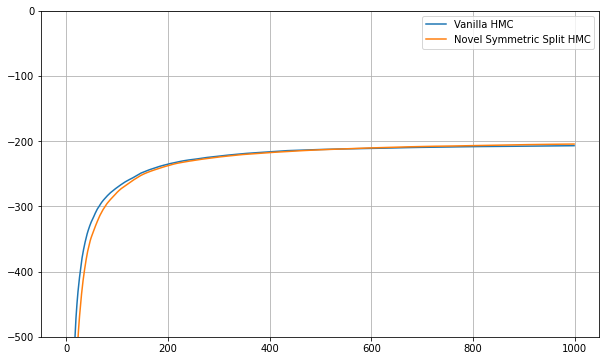

In [14]:
plt.figure(figsize=(10,6))
plt.plot(ll_full, label = 'Vanilla HMC')
plt.plot(ll_s, label = 'Novel Symmetric Split HMC')
plt.ylim([-500,0])
plt.grid()
plt.legend()
plt.show()


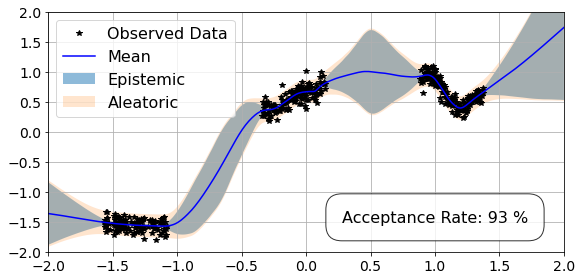

In [15]:
m = pred_list_split[200:].mean(0).to('cpu')
s = pred_list_split[200:].std(0).to('cpu')
s_al = (pred_list_split[200:].var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(8, 4))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(X.numpy(), Y.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(X_test.numpy(), m.numpy(), 'b', rasterized=True)
# Shade between the lower and upper confidence bounds
ax.fill_between(X_test.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(X_test.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
ax.set_ylim([-2, 2])
ax.set_xlim([-2, 2])
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

bbox = {'facecolor': 'white', 'alpha': 0.8, 'pad': 1, 'boxstyle': 'round', 'edgecolor':'black'}
plt.text(1., -1.5, 'Acceptance Rate: 93 %', bbox=bbox, fontsize=16, horizontalalignment='center')


plt.tight_layout()
# plt.savefig('plots/split_hmc.pdf', rasterized=True)
    
plt.show()

In [16]:
m = pred_list_tr_s[200:].mean(0).to('cpu')
s = pred_list_tr_s[200:].std(0).to('cpu')
s_al = (pred_list_tr_s[200:].var(0).to('cpu') + tau_out ** -1) ** 0.5
count_sigma = 0
count_2sigma = 0

for i, p in enumerate(pred_list_tr_s.mean(0)):
    if Y[i] > m[i] + s_al[i] or Y[i] < m[i] - s_al[i]:
        count_sigma += 1
    if Y[i] > m[i] + 2*s_al[i] or Y[i] < m[i] - 2*s_al[i]:
        count_2sigma += 1

print('Proportion of training data outside standard deviation  (0.318): ', count_sigma / X.shape[0])
print('Proportion of training data outside 2 standard deviation (0.05): ', count_2sigma / X.shape[0])




Proportion of training data outside standard deviation  (0.318):  0.3075
Proportion of training data outside 2 standard deviation (0.05):  0.035


## Randomised Split HMC
* As in Neal 1995
* The key difference to the above is `integrator = hamiltorch.Integrator.SPLITTING_RAND`

In [17]:
print(params_init.shape)
integrator = hamiltorch.Integrator.SPLITTING_RAND
sampler = hamiltorch.Sampler.HMC

hamiltorch.set_random_seed(r)
params_hmc_r = hamiltorch.samplers.sample_split_model(net, dataloader_tr, params_init=params_init,
                                                      num_splits=M, num_samples=num_samples,
                                                      step_size=step_size, num_steps_per_sample=L,
                                inv_mass = inv_mass.to(device), integrator=integrator, debug = debug, store_on_GPU=store_on_GPU, burn = burn,
                                sampler = sampler, tau_out=tau_out, tau_list=tau_list, model_loss=model_loss)

params_hmc_gpu = [ll.to(device) for ll in params_hmc_r[1:]]

pred_list_r_split, log_probs_r_split = hamiltorch.predict_model(net, test_loader = dataloader_val, samples=params_hmc_gpu, model_loss=model_loss, tau_out=tau_out, tau_list=tau_list)

pred_list_r_tr, log_probs_r_split_tr = hamiltorch.predict_model(net, x = X.to(device), y=Y.to(device), samples=params_hmc_gpu, model_loss=model_loss, tau_out=tau_out, tau_list=tau_list)

ll_r = torch.zeros(pred_list_r_tr.shape[0])
ll_r[0] = - 0.5 * tau_out * ((pred_list_r_tr[0].cpu() - Y) ** 2).sum(0)
for i in range(pred_list_r_tr.shape[0]):
    ll_r[i] = - 0.5 * tau_out * ((pred_list_r_tr[:i].mean(0).cpu() - Y) ** 2).sum(0)

torch.Size([10401])
Number of splits:  4  , each of batch size  100 

Sampling (Sampler.HMC; Integrator.SPLITTING_RAND)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:09:02 | 0d:00:00:00 | #################### | 1000/1000 | 1.85       
Acceptance Rate 0.68
Number of splits:  1  , each of batch size  500 



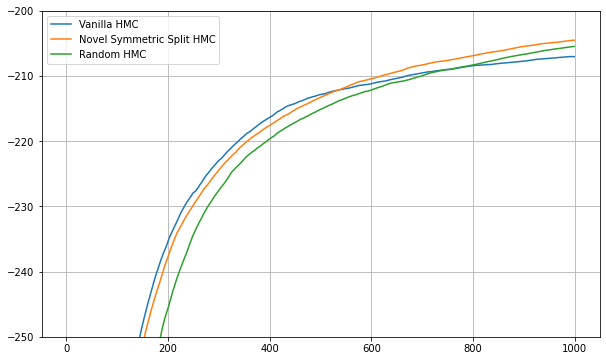

In [18]:
plt.figure(figsize=(10,6))
plt.plot(ll_full, label = 'Vanilla HMC')
plt.plot(ll_s, label = 'Novel Symmetric Split HMC')
plt.plot(ll_r, label = 'Random HMC')
plt.ylim([-250,-200])
plt.grid()
plt.legend()
plt.show()


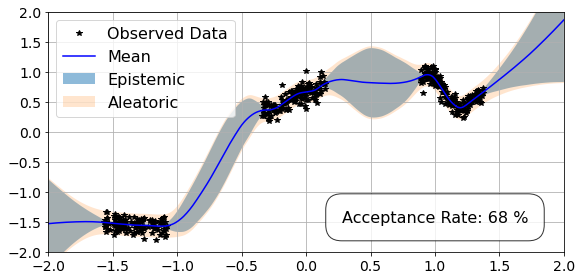

In [19]:
m = pred_list_r_split[200:].mean(0).to('cpu')
s = pred_list_r_split[200:].std(0).to('cpu')
s_al = (pred_list_r_split[200:].var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(8, 4))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(X.numpy(), Y.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(X_test.numpy(), m.numpy(), 'b', rasterized=True)
# Shade between the lower and upper confidence bounds
ax.fill_between(X_test.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(X_test.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
ax.set_ylim([-2, 2])
ax.set_xlim([-2, 2])
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

bbox = {'facecolor': 'white', 'alpha': 0.8, 'pad': 1, 'boxstyle': 'round', 'edgecolor':'black'}
plt.text(1., -1.5, 'Acceptance Rate: 68 %', bbox=bbox, fontsize=16, horizontalalignment='center')


plt.tight_layout()
# plt.savefig('plots/rand_split_hmc.pdf', rasterized=True)
    
plt.show()

In [20]:
m = pred_list_r_tr[200:].mean(0).to('cpu')
s = pred_list_r_tr[200:].std(0).to('cpu')
s_al = (pred_list_r_tr[200:].var(0).to('cpu') + tau_out ** -1) ** 0.5
count_sigma = 0
count_2sigma = 0

for i, p in enumerate(pred_list_r_tr.mean(0)):
    if Y[i] > m[i] + s_al[i] or Y[i] < m[i] - s_al[i]:
        count_sigma += 1
    if Y[i] > m[i] + 2*s_al[i] or Y[i] < m[i] - 2*s_al[i]:
        count_2sigma += 1

print('Proportion of training data outside standard deviation  (0.318): ', count_sigma / X.shape[0])
print('Proportion of training data outside 2 standard deviation (0.05): ', count_2sigma / X.shape[0])




Proportion of training data outside standard deviation  (0.318):  0.3
Proportion of training data outside 2 standard deviation (0.05):  0.035


## Naive Split HMC
* This is just a simple baseline which follows the formulation of full HMC by placing the kinetic energy term in the middle. Hence we set `integrator = hamiltorch.Integrator.SPLITTING_KMID`.

In [21]:
print(params_init.shape)
integrator = hamiltorch.Integrator.SPLITTING_KMID
sampler = hamiltorch.Sampler.HMC

hamiltorch.set_random_seed(r)
params_hmc_k = hamiltorch.samplers.sample_split_model(net, dataloader_tr, params_init=params_init,
                                                      num_splits=M, num_samples=num_samples,
                                                      step_size=step_size, num_steps_per_sample=L,
                                inv_mass = inv_mass.to(device), integrator=integrator, debug = debug, store_on_GPU=store_on_GPU, burn = burn,
                                sampler = sampler, tau_out=tau_out, tau_list=tau_list, model_loss=model_loss)

params_hmc_gpu = [ll.to(device) for ll in params_hmc_k[1:]]

pred_list_k_split, log_probs_k_split = hamiltorch.predict_model(net, test_loader = dataloader_val, samples=params_hmc_gpu, model_loss=model_loss, tau_out=tau_out, tau_list=tau_list)

pred_list_k_tr, log_probs_k_split_tr = hamiltorch.predict_model(net, x = X.to(device), y=Y.to(device), samples=params_hmc_gpu, model_loss=model_loss, tau_out=tau_out, tau_list=tau_list)
ll_k = torch.zeros(pred_list_k_tr.shape[0])
ll_k[0] = - 0.5 * tau_out * ((pred_list_k_tr[0].cpu() - Y) ** 2).sum(0)
for i in range(pred_list_k_tr.shape[0]):
    ll_k[i] = - 0.5 * tau_out * ((pred_list_k_tr[:i].mean(0).cpu() - Y) ** 2).sum(0)



torch.Size([10401])
Number of splits:  4  , each of batch size  100 

Sampling (Sampler.HMC; Integrator.SPLITTING_KMID)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:08:57 | 0d:00:00:00 | #################### | 1000/1000 | 1.86       
Acceptance Rate 0.54
Number of splits:  1  , each of batch size  500 



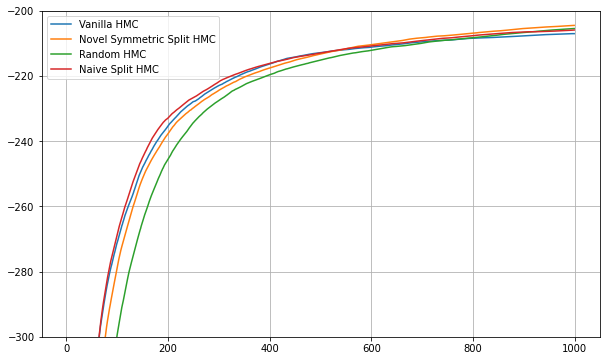

In [22]:
plt.figure(figsize=(10,6))
plt.plot(ll_full, label = 'Vanilla HMC')
plt.plot(ll_s, label = 'Novel Symmetric Split HMC')
plt.plot(ll_r, label = 'Random HMC')
plt.plot(ll_k, label = 'Naive Split HMC')
plt.ylim([-300,-200])
plt.grid()
plt.legend()
plt.show()

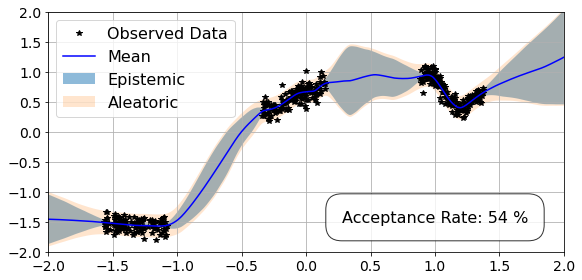

In [25]:
m = pred_list_k_split[200:].mean(0).to('cpu')
s = pred_list_k_split[200:].std(0).to('cpu')
s_al = (pred_list_k_split[200:].var(0).to('cpu') + tau_out ** -1) ** 0.5

f, ax = plt.subplots(1, 1, figsize=(8, 4))

# Get upper and lower confidence bounds
lower, upper = (m - s*2).flatten(), (m + s*2).flatten()
# + aleotoric
lower_al, upper_al = (m - s_al*2).flatten(), (m + s_al*2).flatten()

# Plot training data as black stars
ax.plot(X.numpy(), Y.numpy(), 'k*', rasterized=True)
# Plot predictive means as blue line
ax.plot(X_test.numpy(), m.numpy(), 'b', rasterized=True)
# Shade between the lower and upper confidence bounds
ax.fill_between(X_test.flatten().numpy(), lower.numpy(), upper.numpy(), alpha=0.5, rasterized=True)
ax.fill_between(X_test.flatten().numpy(), lower_al.numpy(), upper_al.numpy(), alpha=0.2, rasterized=True)
ax.set_ylim([-2, 2])
ax.set_xlim([-2, 2])
plt.grid()
ax.legend(['Observed Data', 'Mean', 'Epistemic', 'Aleatoric'], fontsize = fs)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

bbox = {'facecolor': 'white', 'alpha': 0.8, 'pad': 1, 'boxstyle': 'round', 'edgecolor':'black'}
plt.text(1., -1.5, 'Acceptance Rate: 54 %', bbox=bbox, fontsize=16, horizontalalignment='center')


plt.tight_layout()
# plt.savefig('plots/kmid_hmc.pdf', rasterized=True)
    
plt.show()

In [26]:
m = pred_list_k_tr[200:].mean(0).to('cpu')
s = pred_list_k_tr[200:].std(0).to('cpu')
s_al = (pred_list_k_tr[200:].var(0).to('cpu') + tau_out ** -1) ** 0.5
count_sigma = 0
count_2sigma = 0

for i, p in enumerate(pred_list_k_tr.mean(0)):
    if Y[i] > m[i] + s_al[i] or Y[i] < m[i] - s_al[i]:
        count_sigma += 1
    if Y[i] > m[i] + 2*s_al[i] or Y[i] < m[i] - 2*s_al[i]:
        count_2sigma += 1

print('% training data outside standard deviation (31.8):   ', 100 * count_sigma / X.shape[0])
print('% training data outside 2 standard deviation (5.0): ', 100 * count_2sigma / X.shape[0])



% training data outside standard deviation (31.8):    30.75
% training data outside 2 standard deviation (5.0):  3.5
